<a href="https://colab.research.google.com/github/shahsamir24/Brain-tumor-Project/blob/main/Resnet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/MyDrive/d1 with d2.zip'


Archive:  /content/drive/MyDrive/d1 with d2.zip
replace d1 with d2/Testing/glioma/image(1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
from tqdm import tqdm
from warnings import filterwarnings
import pickle
import os
import shutil
import random
import cv2

#Import sklearn modules
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score

#Import tf modules
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import InceptionResNetV2

In [ ]:
train_img = []
train_labels_not_encoded = []

test_img = []
test_labels_not_encoded = []

path_train = '/content/d1 with d2/Training/'  # Update the path to the Training directory in session storage
path_test = '/content/d1 with d2/Testing/'  # Update the path to the Testing directory in session storage

img_size = 180
for i in os.listdir(path_train):
    for j in tqdm(os.listdir(path_train + i)):
        train_img.append(cv2.resize(cv2.imread(path_train + i + '/' + j), (img_size, img_size)))
        train_labels_not_encoded.append(i)

for i in os.listdir(path_test):
    for j in tqdm(os.listdir(path_test + i)):
        test_img.append(cv2.resize(cv2.imread(path_test + i + '/' + j), (img_size, img_size)))
        test_labels_not_encoded.append(i)

train_img = np.array(train_img)
test_img = np.array(test_img)

100%|██████████| 400/400 [00:00<00:00, 454.12it/s]


In [ ]:
y_train = pd.get_dummies(train_labels_not_encoded)
y_test = pd.get_dummies(test_labels_not_encoded)
labels=y_train.columns

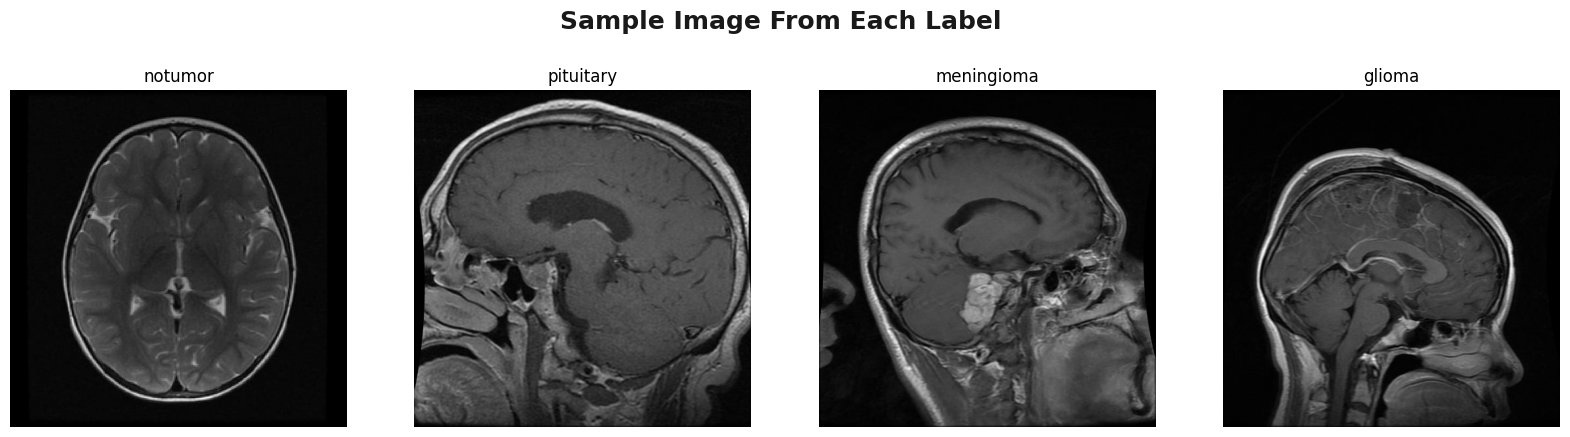

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
         color="black",y=0.61,x=0.4,alpha=0.9)
for count, ele in enumerate(os.listdir(path_train)):
    for j in os.listdir(path_train+ele):
        img= cv2.imread(path_train+ele+'/'+j)
        ax[count].imshow(img)
        ax[count].set_title(ele)
        ax[count].axis('off')
        break

In [ ]:
print("Train size:", train_img.shape[0], "Test size:", test_img.shape[0])

Train size: 6097 Test size: 1579


In [ ]:
y_train

,glioma,meningioma,notumor,pituitary
0,False,False,True,False
1,False,False,True,False
2,False,False,True,False
3,False,False,True,False
4,False,False,True,False
...,...,...,...,...
6092,True,False,False,False
6093,True,False,False,False
6094,True,False,False,False
6095,True,False,False,False


In [ ]:
def clear_previous_calculations():
    try:
        shutil.rmtree("logs")
    except Exception as e:
        pass

    for i in ["tumor_model.h5", "predictions.pkl"]:
        try:
            os.remove(i)
        except Exception as e:
            pass

In [ ]:
def get_model():
    data_augmentation = Sequential([
        layers.RandomFlip("horizontal_and_vertical", input_shape=(img_size, img_size, 3)),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.1)
    ])
    resnet = InceptionResNetV2(include_top=False, input_shape=(img_size, img_size, 3))
    model = Sequential([
        data_augmentation,
        resnet,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(rate=0.4),
        layers.Dense(4, activation='softmax')
    ])
    return model


In [ ]:
def get_callbacks():
    tensorboard = TensorBoard(log_dir = 'logs', histogram_freq=1)
    checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2,
                                  mode='auto',verbose=1, min_lr=0.000001)
    return [tensorboard,checkpoint,reduce_lr]

In [ ]:
def get_fig_and_axes_list(plot_count,column_number=2):
    """
    This function takes in the number of subplots to be plotted and the desired number of columns for the subplot grid.
    It then calculates the number of rows required and generates a matplotlib figure with the given number of subplots
    in a grid with the desired number of columns.

    Args:
    - plot_count: int, the number of subplots to be plotted
    - column_number: int, the number of columns in the subplot grid. Default value is 2.

    Returns:
    - fig: matplotlib Figure object, the generated figure
    - axes_list: list of matplotlib Axes objects, the axes of the subplots in the figure
    """
    reminder_num = plot_count % column_number
    row_num = (plot_count // column_number) + (reminder_num > 0)
    axes_list = []
    row_number_alignment = np.ones((row_num, column_number), dtype="int")
    if reminder_num != 0:
        row_number_alignment[-1,-(column_number - reminder_num):] = 0
    coefficient = (3.5 if plot_count==1 else 5.2)
    col_size = coefficient*column_number
    row_size = coefficient*row_num
    fig = plt.figure(figsize=(col_size, row_size), layout="constrained")
    spec = fig.add_gridspec(row_num, column_number)
    for i in range(row_number_alignment.shape[0]):
        for j in range(row_number_alignment.shape[1]):
            if row_number_alignment[i,j] == 1:
                ax = fig.add_subplot(spec[i,j])
                axes_list.append(ax)
    return fig,axes_list

In [ ]:
def get_axes_list(length, column_number=2):
    fig, axes_list = get_fig_and_axes_list(length, column_number=column_number )
    return axes_list

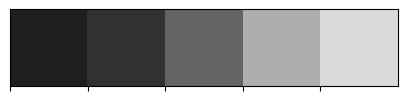

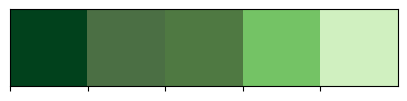

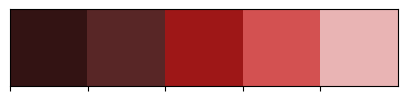

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) #Supress warnings
clear_previous_calculations()
model = get_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

219055592/219055592 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 inception_resnet_v2 (Funct  (None, 4, 4, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 4)                 6148      
                                                     

In [ ]:
epochs = 10
batch_size=32
all_callbacks = get_callbacks()
history = model.fit(train_img, y_train, validation_split=0.1,  epochs=epochs, batch_size=batch_size,
                    callbacks=all_callbacks,  shuffle=True, verbose=1, workers=1)
model.load_weights('effnet.h5')

Epoch 1/10
172/172 [==============================] - ETA: 0s - loss: 0.3618 - accuracy: 0.8837
Epoch 1: val_accuracy improved from -inf to 0.47541, saving model to effnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


172/172 [==============================] - 191s 537ms/step - loss: 0.3618 - accuracy: 0.8837 - val_loss: 1.4257 - val_accuracy: 0.4754 - lr: 0.0010
Epoch 2/10
172/172 [==============================] - ETA: 0s - loss: 0.2100 - accuracy: 0.9337
Epoch 2: val_accuracy improved from 0.47541 to 0.67869, saving model to effnet.h5
172/172 [==============================] - 87s 508ms/step - loss: 0.2100 - accuracy: 0.9337 - val_loss: 1.0740 - val_accuracy: 0.6787 - lr: 0.0010
Epoch 3/10
172/172 [==============================] - ETA: 0s - loss: 0.1559 - accuracy: 0.9486
Epoch 3: val_accuracy improved from 0.67869 to 0.91148, saving model to effnet.h5
172/172 [==============================] - 92s 534ms/step - loss: 0.1559 - accuracy: 0.9486 - val_loss: 0.2033 - val_accuracy: 0.9115 - lr: 0.0010
Epoch 4/10
172/172 [==============================] - ETA: 0s - loss: 0.1357 - accuracy: 0.9523
Epoch 4: val_accuracy did not improve from 0.91148
172/172 [==============================] - 81s 473ms/st

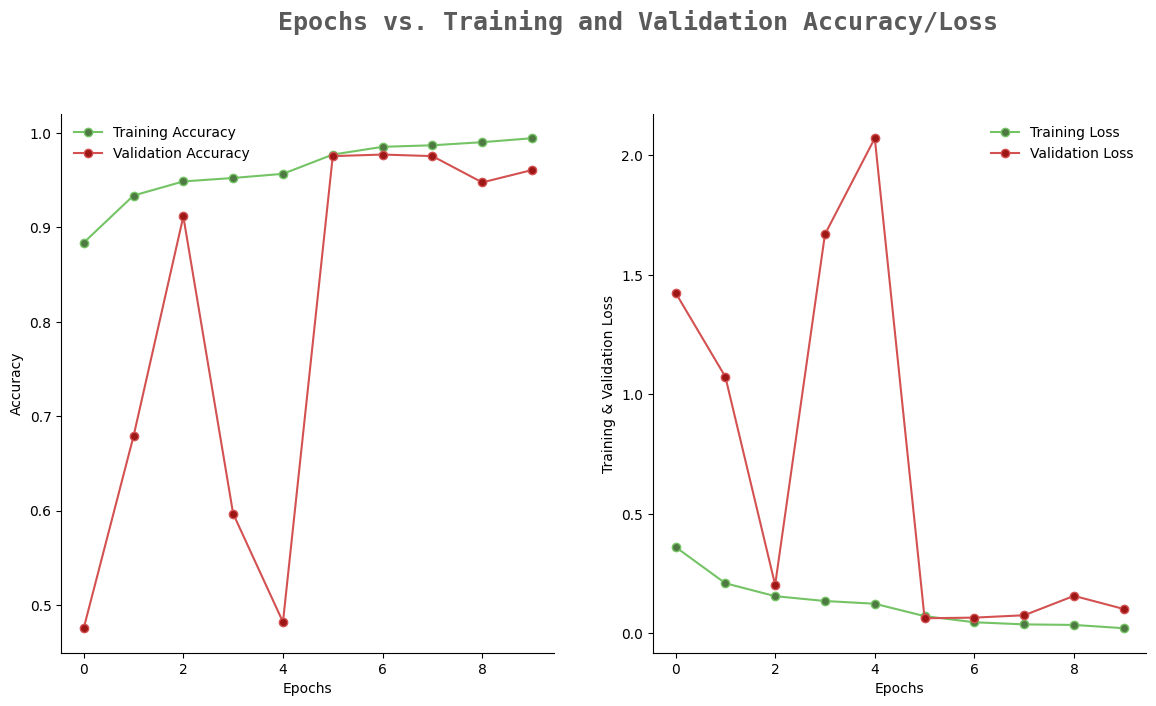

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs_count = [i for i in range(len(train_acc))]

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss', size=18, fontweight='bold',
         fontname='monospace', color=colors_dark[1], y=1, x=0.28, alpha=0.8)

sns.despine()
ax[0].plot(epochs_count, train_acc, marker='o',markerfacecolor=colors_green[2], color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs_count, val_acc, marker='o',markerfacecolor=colors_red[2], color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs_count, train_loss, marker='o', markerfacecolor=colors_green[2], color=colors_green[3],
           label='Training Loss')
ax[1].plot(epochs_count, val_loss, marker='o', markerfacecolor=colors_red[2], color=colors_red[3],
           label='Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred_prob = model.predict(test_img)
pred = np.argmax(pred_prob,axis=1)
y_test_encoded = np.argmax(y_test.to_numpy(),axis=1)
y_train_encoded = np.argmax(y_train.to_numpy(),axis=1)
train_pred_proba = model.predict(train_img)
train_pred = np.argmax(train_pred_proba,axis=1)

191/191 [==============================] - 22s 113ms/step


In [ ]:
boosting_model = GradientBoostingClassifier()
boosting_model.fit(train_pred_proba,  y_train_encoded)
meta_test = boosting_model.predict(pred_prob)


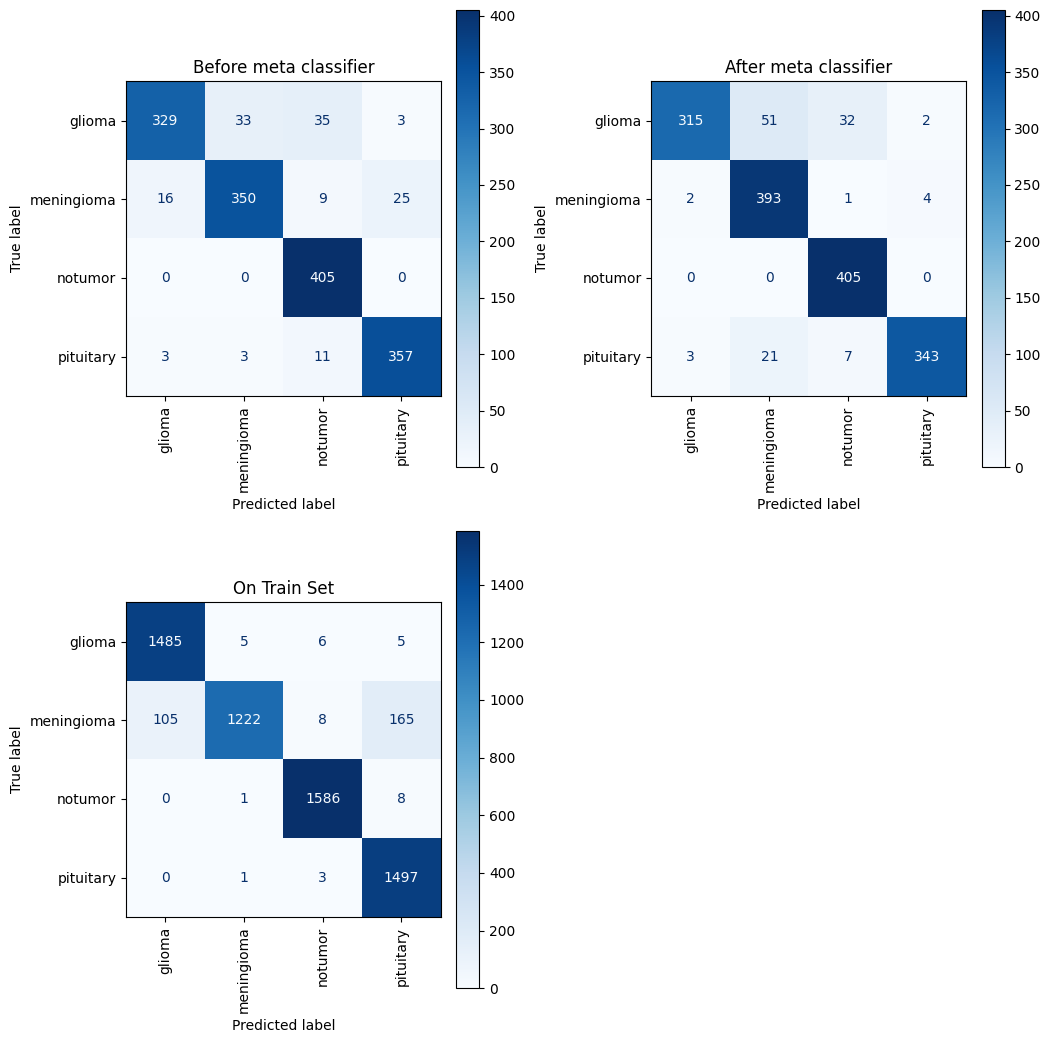

In [ ]:
axes = get_axes_list(3)

axes[0].set_title("Before meta classifier")
ConfusionMatrixDisplay.from_predictions(y_test_encoded, pred, display_labels=labels,
                                        cmap='Blues', ax=axes[0], xticks_rotation="vertical")

axes[1].set_title("After meta classifier")
ConfusionMatrixDisplay.from_predictions(y_test_encoded, meta_test, display_labels=labels,
                                        cmap='Blues', ax=axes[1], xticks_rotation="vertical")

axes[2].set_title("On Train Set")
ConfusionMatrixDisplay.from_predictions(y_train_encoded, train_pred, display_labels=labels,
                                        cmap='Blues', ax=axes[2], xticks_rotation="vertical")

In [ ]:
before = roc_auc_score(y_test, pred_prob,multi_class="ovo")
print("Before meta classifier:\n", classification_report(y_test_encoded,pred),"\n RUC-AUC:", before)

Before meta classifier:
               precision    recall  f1-score   support

           0       0.95      0.82      0.88       400
           1       0.91      0.88      0.89       400
           2       0.88      1.00      0.94       405
           3       0.93      0.95      0.94       374

    accuracy                           0.91      1579
   macro avg       0.91      0.91      0.91      1579
weighted avg       0.91      0.91      0.91      1579
 
 RUC-AUC: 0.9830897312089132


In [ ]:
after = roc_auc_score(y_test, boosting_model.predict_proba(pred_prob),multi_class="ovo")
print("After meta classifier:\n", classification_report(y_test_encoded, meta_test),"\n RUC-AUC:", after)

After meta classifier:
               precision    recall  f1-score   support

           0       0.98      0.79      0.87       400
           1       0.85      0.98      0.91       400
           2       0.91      1.00      0.95       405
           3       0.98      0.92      0.95       374

    accuracy                           0.92      1579
   macro avg       0.93      0.92      0.92      1579
weighted avg       0.93      0.92      0.92      1579
 
 RUC-AUC: 0.9828026828995602


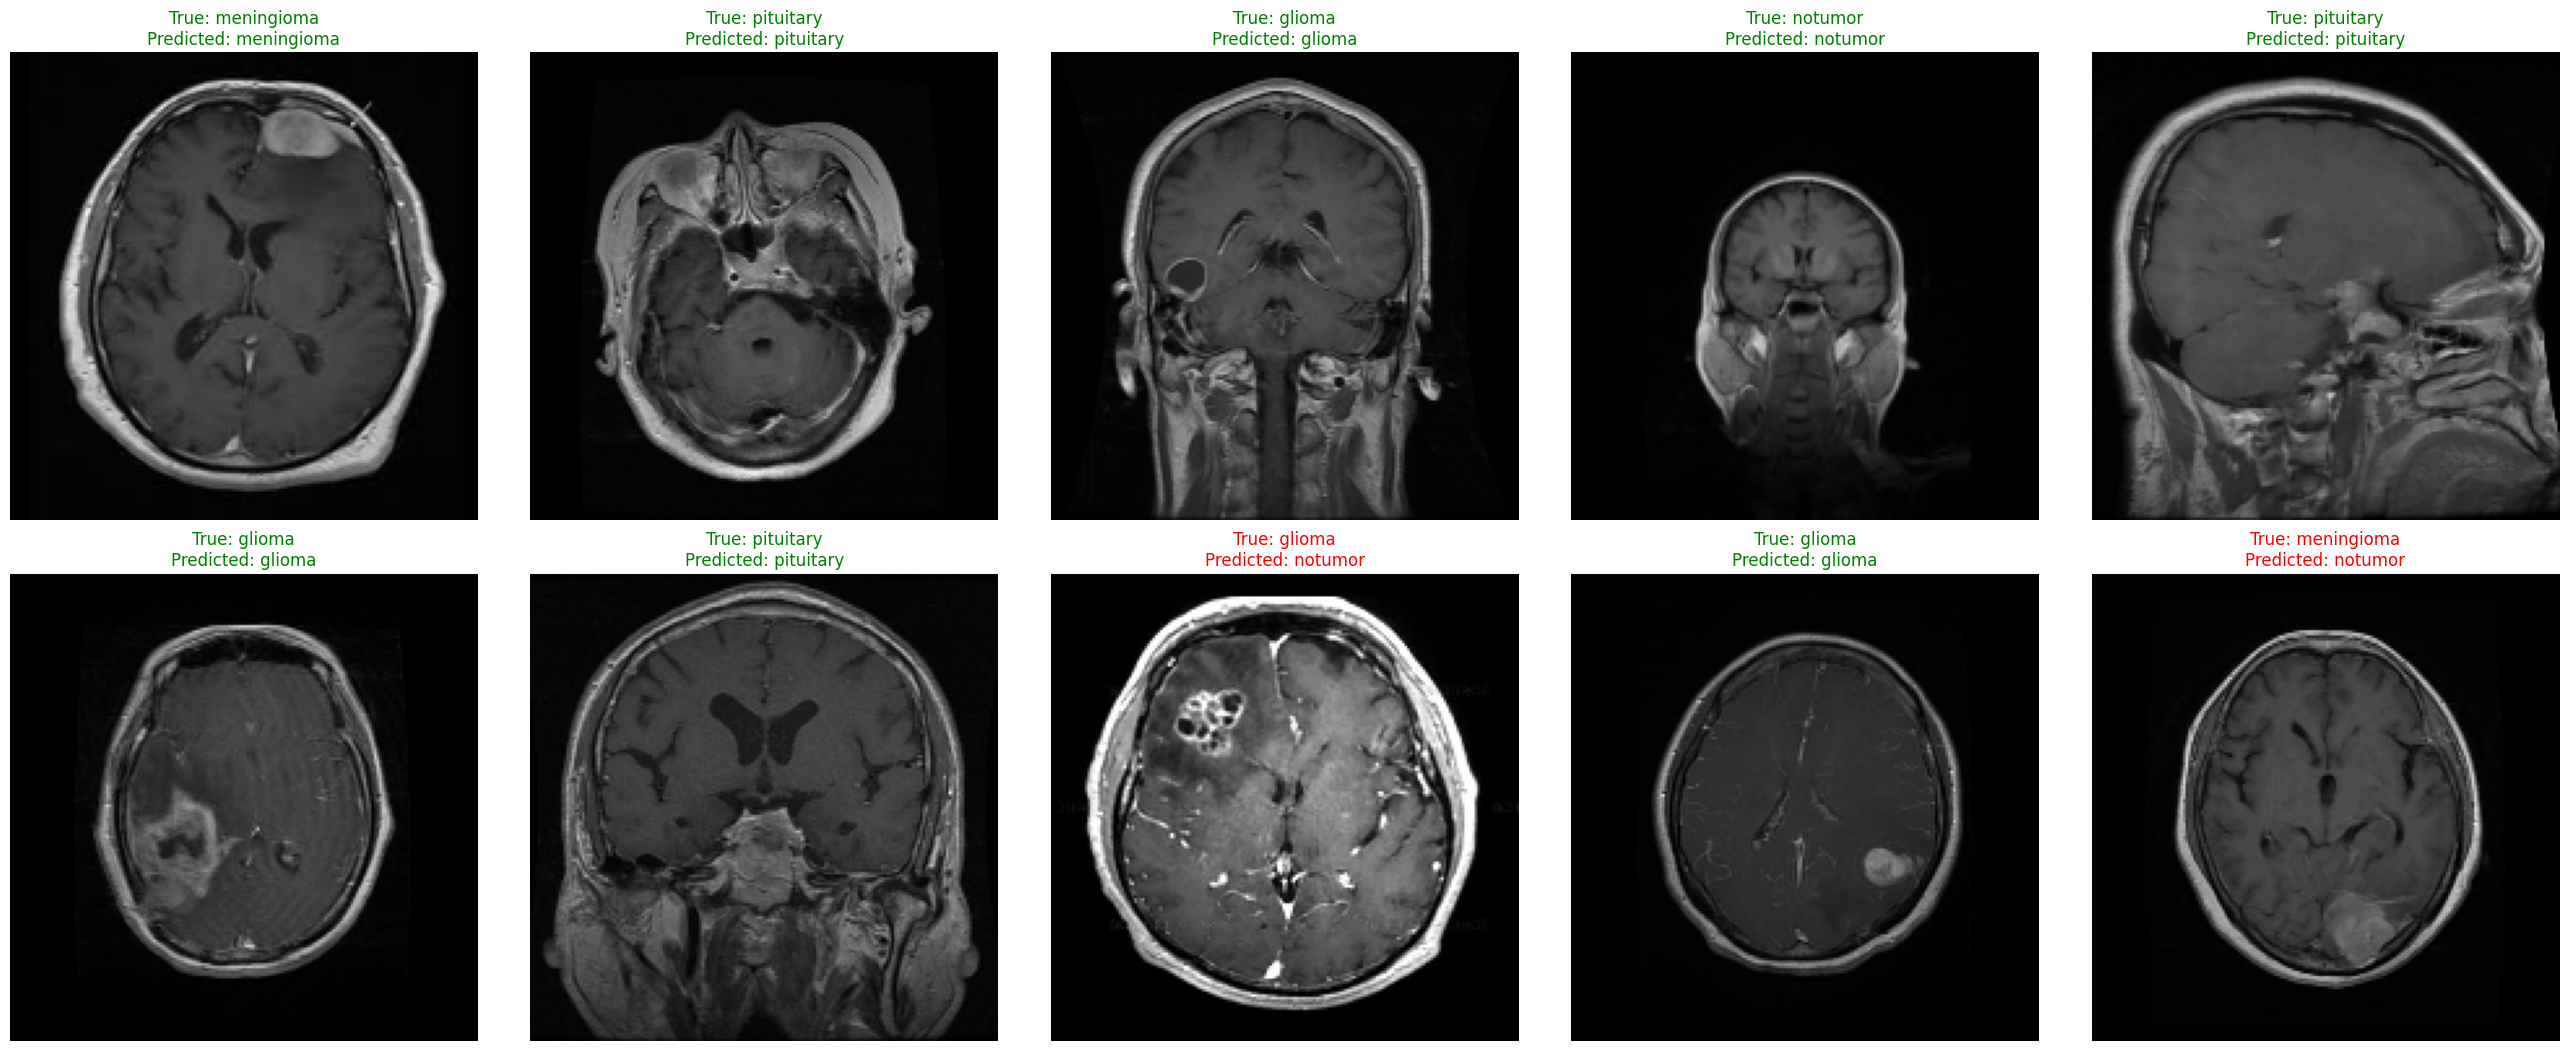

In [ ]:
fig,ax_list = get_fig_and_axes_list(10,5)
random_image_index = np.random.randint(test_img.shape[0], size=10)
for count, ele in enumerate(random_image_index):
    ax_list[count]
    ax_list[count].imshow(test_img[ele])
    color = ("green" if pred[ele] == y_test_encoded[ele] else "red")
    ax_list[count].set_title(f"True: {test_labels_not_encoded[ele]}\nPredicted: { labels[pred[ele]] }", color=color)
    ax_list[count].axis('off')